### MyAniMate: Anime Recommendation System

In [121]:
#Import the necessary libraries: 
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import nltk.corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

from fuzzywuzzy import fuzz
from fuzzywuzzy import process


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saiya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saiya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\saiya\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saiya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### 1.) Data Observations and Clean Up

Data retrieved from: https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset/data . The data is from myAnimeList

First, we will observe the characteristics of this data and jot down our observations by converting the following CSV file into a Pandas DataFrame. 


In [122]:
animedf = pd.read_csv('anime-dataset-2023.csv')
animedf

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24900,55731,Wu Nao Monu,UNKNOWN,无脑魔女,UNKNOWN,"Comedy, Fantasy, Slice of Life",No description available for this anime.,ONA,15.0,"Jul 4, 2023 to ?",...,UNKNOWN,Web manga,Unknown,PG-13 - Teens 13 or older,UNKNOWN,24723,0,UNKNOWN,0,https://cdn.myanimelist.net/images/anime/1386/...
24901,55732,Bu Xing Si: Yuan Qi,Blader Soul,捕星司·源起,UNKNOWN,"Action, Adventure, Fantasy",No description available for this anime.,ONA,18.0,"Jul 27, 2023 to ?",...,UNKNOWN,Web novel,Unknown,PG-13 - Teens 13 or older,0.0,0,0,UNKNOWN,0,https://cdn.myanimelist.net/images/anime/1383/...
24902,55733,Di Yi Xulie,The First Order,第一序列,UNKNOWN,"Action, Adventure, Fantasy, Sci-Fi",No description available for this anime.,ONA,16.0,"Jul 19, 2023 to ?",...,UNKNOWN,Web novel,Unknown,PG-13 - Teens 13 or older,0.0,0,0,UNKNOWN,0,https://cdn.myanimelist.net/images/anime/1130/...
24903,55734,Bokura no Saishuu Sensou,UNKNOWN,僕らの最終戦争,UNKNOWN,UNKNOWN,A music video for the song Bokura no Saishuu S...,Music,1.0,"Apr 23, 2022",...,UNKNOWN,Original,3 min,PG-13 - Teens 13 or older,0.0,0,0,UNKNOWN,0,https://cdn.myanimelist.net/images/anime/1931/...


In [123]:
animedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   anime_id      24905 non-null  int64 
 1   Name          24905 non-null  object
 2   English name  24905 non-null  object
 3   Other name    24905 non-null  object
 4   Score         24905 non-null  object
 5   Genres        24905 non-null  object
 6   Synopsis      24905 non-null  object
 7   Type          24905 non-null  object
 8   Episodes      24905 non-null  object
 9   Aired         24905 non-null  object
 10  Premiered     24905 non-null  object
 11  Status        24905 non-null  object
 12  Producers     24905 non-null  object
 13  Licensors     24905 non-null  object
 14  Studios       24905 non-null  object
 15  Source        24905 non-null  object
 16  Duration      24905 non-null  object
 17  Rating        24905 non-null  object
 18  Rank          24905 non-null  object
 19  Popu

In [124]:
#Lets understand what kind of columns we have. We only need certain kinds of columns to gain important info for our rec system
animedf.columns

Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Genres',
       'Synopsis', 'Type', 'Episodes', 'Aired', 'Premiered', 'Status',
       'Producers', 'Licensors', 'Studios', 'Source', 'Duration', 'Rating',
       'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members', 'Image URL'],
      dtype='object')

In [125]:
#Convert Score, Scored by, Favorites into int and floats:

animedf['Score'] = animedf['Score'].replace(to_replace='UNKNOWN', value=None)
animedf['Score'] = animedf['Score'].astype(float)

animedf['Scored By'] = animedf['Scored By'].replace(to_replace='UNKNOWN', value=None)
animedf['Scored By'] = animedf['Scored By'].astype(float)


animedf['Favorites'] = animedf['Favorites'].astype(int)



In [126]:
animedf['Type'] #type columns indicates if its a movie or tv show. 

0           TV
1        Movie
2           TV
3           TV
4           TV
         ...  
24900      ONA
24901      ONA
24902      ONA
24903    Music
24904    Music
Name: Type, Length: 24905, dtype: object

In [127]:
animedf['Type'].value_counts()

Type
TV         7597
Movie      4381
OVA        4076
ONA        3533
Music      2686
Special    2558
UNKNOWN      74
Name: count, dtype: int64

Here we are exploring the "Type" column more in-depth because we want our anime recommendation system to only focus on TV, Movie, OVA, ONA and Specials. We notice here that we have "UNKNOWNS" and "MUSIC" which in a content based recommendation system may not be as significant to the anime experience. We may need to perform some data cleaning and keep necessary information columns to help build our recommendation system.

In [128]:
#Check for null values:
animedf.isnull().sum() #We may be seeing more 0s because we didn't fix up the "UNKNOWNS" and missing descriptions.

anime_id           0
Name               0
English name       0
Other name         0
Score           9213
Genres             0
Synopsis           0
Type               0
Episodes           0
Aired              0
Premiered          0
Status             0
Producers          0
Licensors          0
Studios            0
Source             0
Duration           0
Rating             0
Rank               0
Popularity         0
Favorites          0
Scored By       9213
Members            0
Image URL          0
dtype: int64

In [129]:
animedf.head()

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


So far, we can indicate the name, score, scored by, genre type, synopsis (summary), type, rating, and favorites. Popularity and rank might be redundant here and might lead to multicollinearity. I believe these will be the most necessary columns in order to build the recommender system. For now we will also keep anime_id if we need to reference back to a unique case or outlier. But it will not be included in the model.

##### Other observations on data before cleaning:

1.) Dataset focuses on the anime type and its other characteristics such as episode amount, release date, studio creation, etc. It provides in-depth information on the anime listed. 

2.) We may face limitations due to the dataset being focused on the 2023 lineup of data in MyAnimeList and may not be up to date as well as its a dataset from Kaggle. It may not reflect current anime trends today but understand anime trends last year among users on that website.

3.) All of the column values are objects. 

In [130]:
#Now lets clean up our data to keep relevant features. Do this by making new df called animedf_clean

#1. Drop the "English Name" and "Other Name" as well as other unnecessary columns. We notice that "English Name" has "UNKNOWNS" Listed. So we should keep "Name" only. 
animedf_clean = animedf.drop(['Other name', 'Episodes','Duration','Rank','Popularity','Members', 'Premiered', 'Aired', 'Status'], axis=1)
animedf_clean

,anime_id,Name,English name,Score,Genres,Synopsis,Type,Producers,Licensors,Studios,Source,Rating,Favorites,Scored By,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,R - 17+ (violence & profanity),78525,914193.0,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,R - 17+ (violence & profanity),1448,206248.0,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,PG-13 - Teens 13 or older,15035,356739.0,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,"Bandai Visual, Dentsu, Victor Entertainment, T...","Funimation, Bandai Entertainment",Sunrise,Original,PG-13 - Teens 13 or older,613,42829.0,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,"TV Tokyo, Dentsu",Illumitoon Entertainment,Toei Animation,Manga,PG - Children,14,6413.0,https://cdn.myanimelist.net/images/anime/7/215...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24900,55731,Wu Nao Monu,UNKNOWN,NaN,"Comedy, Fantasy, Slice of Life",No description available for this anime.,ONA,UNKNOWN,UNKNOWN,UNKNOWN,Web manga,PG-13 - Teens 13 or older,0,NaN,https://cdn.myanimelist.net/images/anime/1386/...
24901,55732,Bu Xing Si: Yuan Qi,Blader Soul,NaN,"Action, Adventure, Fantasy",No description available for this anime.,ONA,UNKNOWN,UNKNOWN,UNKNOWN,Web novel,PG-13 - Teens 13 or older,0,NaN,https://cdn.myanimelist.net/images/anime/1383/...
24902,55733,Di Yi Xulie,The First Order,NaN,"Action, Adventure, Fantasy, Sci-Fi",No description available for this anime.,ONA,UNKNOWN,UNKNOWN,UNKNOWN,Web novel,PG-13 - Teens 13 or older,0,NaN,https://cdn.myanimelist.net/images/anime/1130/...
24903,55734,Bokura no Saishuu Sensou,UNKNOWN,NaN,UNKNOWN,A music video for the song Bokura no Saishuu S...,Music,UNKNOWN,UNKNOWN,UNKNOWN,Original,PG-13 - Teens 13 or older,0,NaN,https://cdn.myanimelist.net/images/anime/1931/...


In [131]:
animedf_clean['Synopsis'].tail(50)

24855          Music video for the song TRIPPER by Kankan.
24856    Music video for the song Fins by Tsunomaki Wat...
24857             No description available for this anime.
24858    Music video for the song Twilight (#1 Abstract...
24859             No description available for this anime.
24860    Music video for the song Sayonara Wonderland b...
24861    In the majestic fantasy world, how does the pr...
24862    Music video for the song Denki Groove 30-shuun...
24863     Music video for the song Gin Kkum by SE SO NEON.
24864    Music video for the song Another day, another ...
24865    Music video for the original song Baka Bakka b...
24866             No description available for this anime.
24867      Second season of Boku no Kokoro no Yabai Yatsu.
24868    Seiichi is bored with his routine life as a te...
24869             No description available for this anime.
24870             No description available for this anime.
24871             No description available for this anim

In [132]:
#Filter and remove "UNKNOWN" and "Music" types we only want our recommender system to recommend users movies, tv shows, specials, etc.
animedf_clean = animedf_clean[(animedf_clean['Type'] != 'UNKNOWN') & (animedf_clean['Type'] != 'Music')]
animedf_clean['Type'].value_counts()

Type
TV         7597
Movie      4381
OVA        4076
ONA        3533
Special    2558
Name: count, dtype: int64

After filtering out the types, we should check if our genres and synopsis are unknown or include no description. If these are left in our recommendation system, we will face issues with our actual recommendations. To do so, let's illustrate the unknown values and ensure they are randomly distributed (via Heatmap). If they are, we can remove them but if they aren't, we may need to impute or modify them.

In [133]:
#Replace Synopsis and other columns that are missing with '':
animedf_clean['Synopsis'] = animedf_clean['Synopsis'].replace(to_replace='No description available for this anime.', value='')

#Replace other column values that are 'UNKNOWN' to '':
animedf_clean = animedf_clean.replace(to_replace='UNKNOWN', value='')

animedf_clean = animedf_clean.replace(to_replace='\n', value='')

C:\Users\saiya\AppData\Local\Temp\ipykernel_1980\2327155648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animedf_clean['Synopsis'] = animedf_clean['Synopsis'].replace(to_replace='No description available for this anime.', value='')


In [134]:
#Lets try merging the name and english name columns:

animedf_clean['English name'] = animedf_clean['English name'].replace(to_replace='', value=None)
animedf_clean['English name'] = animedf_clean['English name'].fillna(animedf_clean['Name'])
#animedf_clean['Names'] = animedf_clean['Name'] + ' ' + animedf_clean['English name']

animedf_clean.tail(50)

,anime_id,Name,English name,Score,Genres,Synopsis,Type,Producers,Licensors,Studios,Source,Rating,Favorites,Scored By,Image URL
24804,55607,Cannibal Seijin,CannibAlien,NaN,"Comedy, Horror, Sci-Fi",The globe has been taken over by alien beings ...,Movie,,,,Original,R+ - Mild Nudity,0,NaN,https://cdn.myanimelist.net/images/anime/1609/...
24805,55608,Maehwa,Maehwa,NaN,"Action, Fantasy",Music video for the song Maehwa by Kim Yuna. S...,ONA,,,,Web manga,R - 17+ (violence & profanity),0,NaN,https://cdn.myanimelist.net/images/anime/1330/...
24806,55609,Chouetsu Jin Shinriki,Chouetsu Jin Shinriki,NaN,Fantasy,Rather than being about Asahara's personal mys...,OVA,,,,Original,G - All Ages,0,NaN,https://cdn.myanimelist.net/images/anime/1517/...
24807,55610,Souseiki,Souseiki,NaN,Fantasy,As Shoko Asahara is depicted in a less embelli...,OVA,,,,Original,G - All Ages,0,NaN,https://cdn.myanimelist.net/images/anime/1704/...
24808,55611,Watashi no shinri jissen-ki,Watashi no shinri jissen-ki,NaN,Fantasy,,OVA,,,,Original,G - All Ages,0,NaN,https://cdn.myanimelist.net/images/anime/1142/...
24809,55612,Hikari: Be My Light,Hikari: Be My Light,NaN,"Boys Love, Drama",He is the only light. A story about an office ...,ONA,,,,Original,PG-13 - Teens 13 or older,1,NaN,https://cdn.myanimelist.net/images/anime/1468/...
24812,55615,BECOME THE CASTELLAN IN ANOTHER WORLD,Starting from Today I'll Work as a City Lord,NaN,"Action, Comedy",When a gamer and homebody starts the buff for ...,ONA,,,,Other,PG-13 - Teens 13 or older,0,NaN,https://cdn.myanimelist.net/img/sp/icon/apple-...
24813,55616,Fuufu Koukan: Modorenai Yoru,Fuufu Koukan: Modorenai Yoru,NaN,Hentai,"The story centres on two married couples, Miha...",ONA,Shueisha,,Studio Hokiboshi,Manga,Rx - Hentai,0,NaN,https://cdn.myanimelist.net/images/anime/1939/...
24815,55618,Milk no Kevin the Movie,Milk no Kevin the Movie,NaN,Drama,Takeru Daigo is a boy living in Tokyo who does...,Movie,,,,Original,G - All Ages,0,NaN,https://cdn.myanimelist.net/images/anime/1650/...
24817,55622,Haruzora to Akizora,Spring Sky and Fall Sky,NaN,Drama,,Movie,,,,Original,G - All Ages,0,NaN,https://cdn.myanimelist.net/images/anime/1832/...


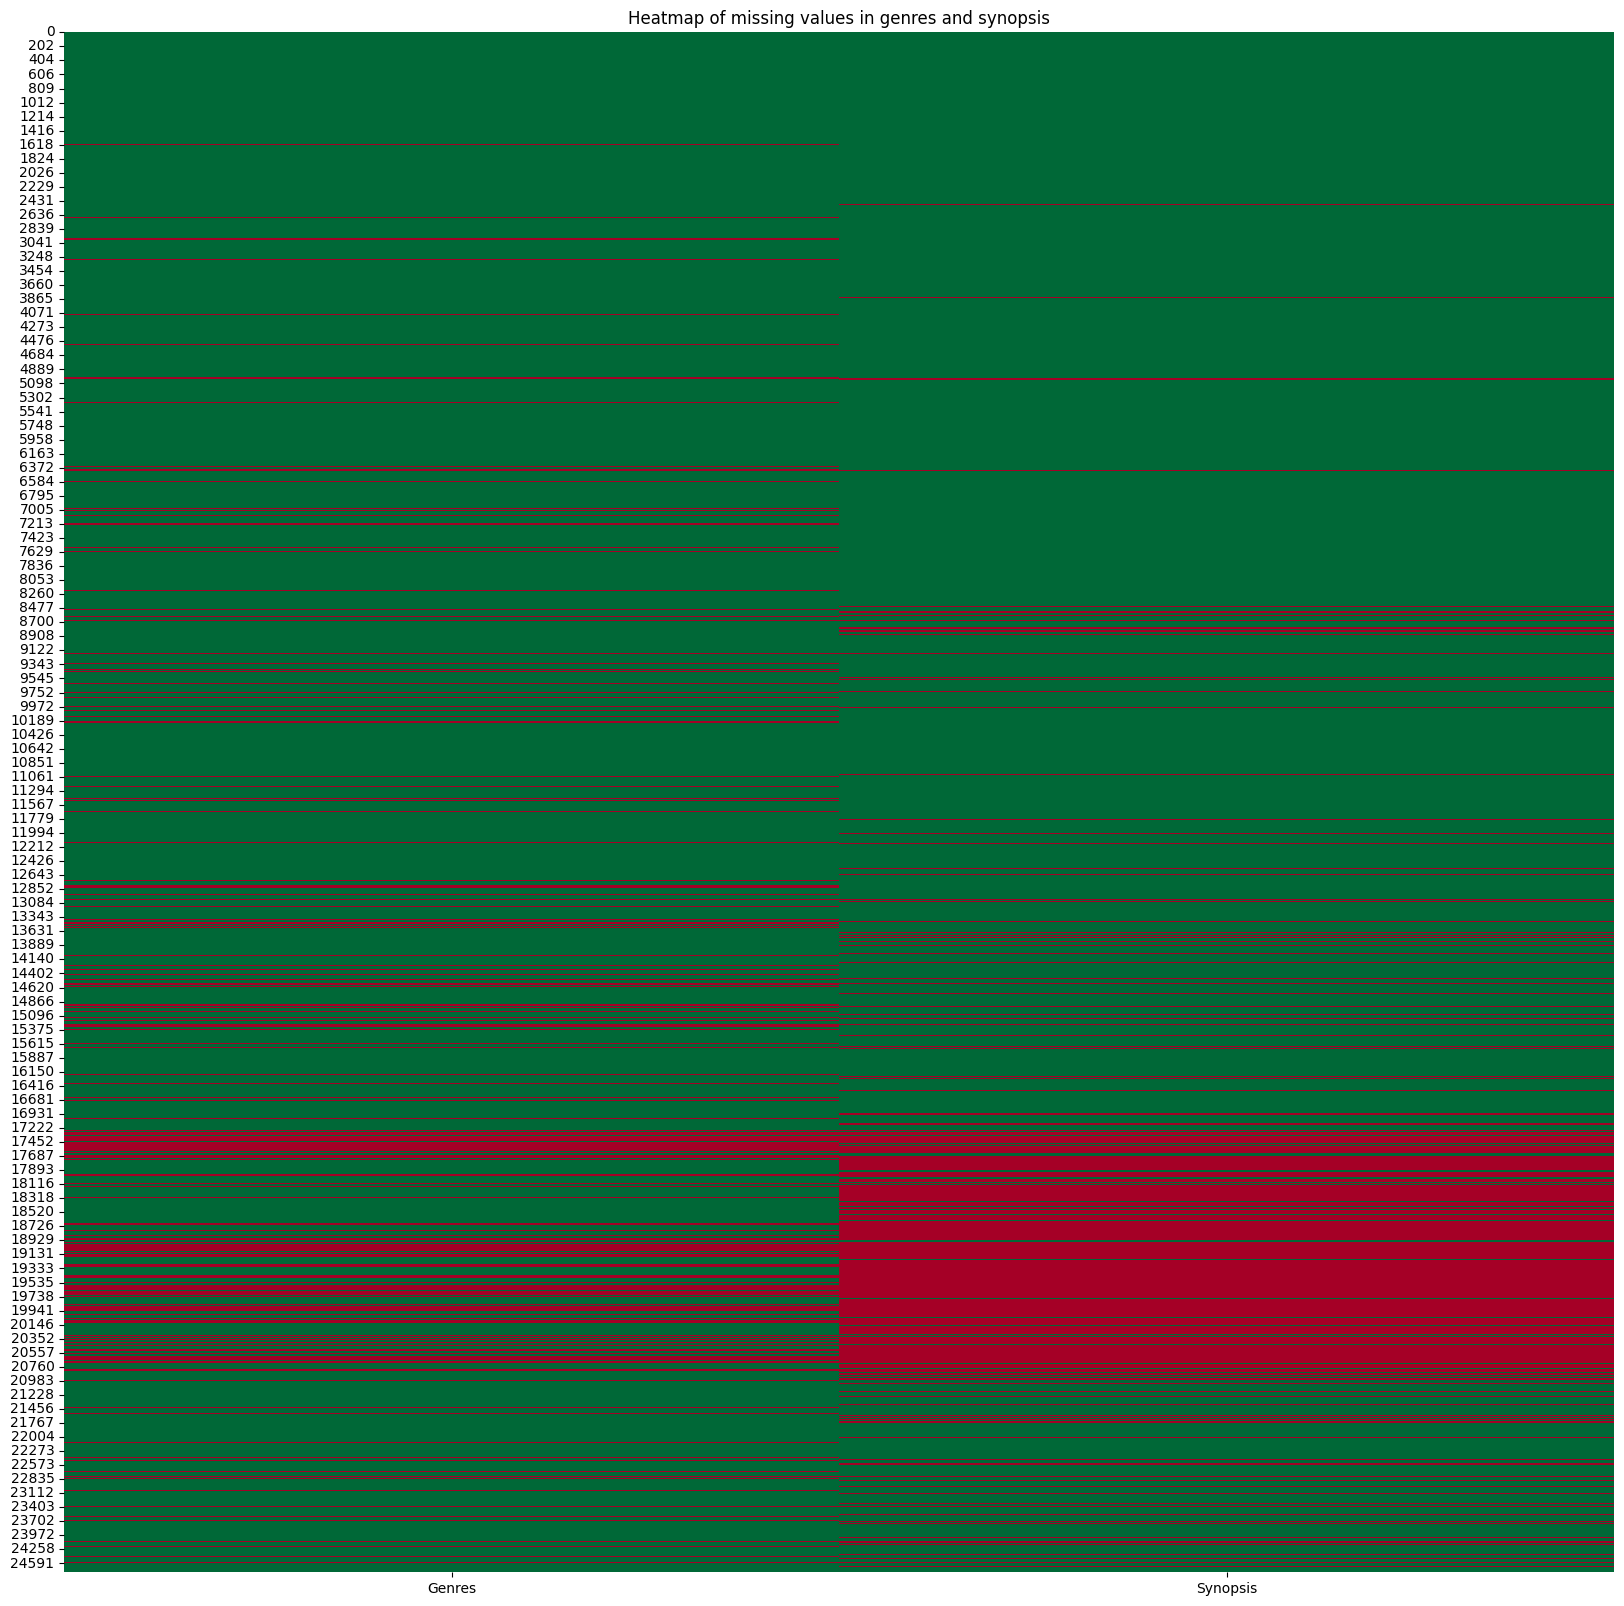

In [135]:
# Select only the genres and synopsis columns
subset = animedf_clean[['Genres', 'Synopsis']].apply(lambda x: x=='')

# Create a boolean DataFrame where True indicates a missing value
missing = subset.astype(int)

# Create the heatmap
plt.figure(figsize=(20,20))
sns.heatmap(missing, cbar=False, cmap='RdYlGn_r')
plt.title('Heatmap of missing values in genres and synopsis')
plt.show()

#Key finding: We notice a HUGE clustering at a specific area in Synopsis while genres seem randomly distributed. This indicates that are null values aren't distributed at random for that column. let's look deeper into this.
#Green is True, Red is False
                

In [136]:
animedf_clean[17222:18726].tail(50) #review the range of indices by splicing. 

,anime_id,Name,English name,Score,Genres,Synopsis,Type,Producers,Licensors,Studios,Source,Rating,Favorites,Scored By,Image URL
20239,47527,Wang Xiong Li Xiong Meiwan Meiliao De Gushi,Wang Xiong Li Xiong Meiwan Meiliao De Gushi,NaN,Comedy,,ONA,,,,Original,G - All Ages,0,NaN,https://cdn.myanimelist.net/images/anime/1469/...
20240,47528,Wang Xiong Li Xiong Meiwan Meiliao De Gushi Fa...,Wang Xiong Li Xiong Meiwan Meiliao De Gushi Fa...,NaN,,,ONA,,,,Original,G - All Ages,0,NaN,https://cdn.myanimelist.net/images/anime/1529/...
20241,47530,Kaixin Dongwuyuan,Kaixin Dongwuyuan,NaN,,,TV,,,,Original,PG - Children,0,NaN,https://cdn.myanimelist.net/images/anime/1574/...
20242,47532,Jinpai Bang Bang Bang,Jinpai Bang Bang Bang,NaN,Comedy,,TV,,,,Original,G - All Ages,0,NaN,https://cdn.myanimelist.net/images/anime/1868/...
20243,47533,Jinpai Bang Bang Bang: Jia Yu Xiwang,Jinpai Bang Bang Bang: Jia Yu Xiwang,NaN,Comedy,,TV,,,,Original,G - All Ages,0,NaN,https://cdn.myanimelist.net/images/anime/1190/...
20244,47534,Jinpai Bang Bang Bang: Ai Yu Mengxiang,Jinpai Bang Bang Bang: Ai Yu Mengxiang,NaN,Comedy,,TV,,,,Original,PG - Children,0,NaN,https://cdn.myanimelist.net/images/anime/1310/...
20245,47535,Yu Jian Tuzki,Yu Jian Tuzki,NaN,"Comedy, Fantasy",,ONA,,,,Original,G - All Ages,0,NaN,https://cdn.myanimelist.net/images/anime/1419/...
20246,47537,Inou no AICis: ESP & High School Detective,AICis the Supernatural,5.76,"Mystery, Supernatural",The anime is set in the fictional Geso ward in...,ONA,,,,Original,PG-13 - Teens 13 or older,10,148.0,https://cdn.myanimelist.net/images/anime/1199/...
20247,47538,Haishang Si Lu: Nan Zhubao Bao,Haishang Si Lu: Nan Zhubao Bao,NaN,,,TV,,,,Original,PG - Children,0,NaN,https://cdn.myanimelist.net/images/anime/1907/...
20248,47541,Chaoji Xiaoxiong BOOMi,Super BOOMi,NaN,Fantasy,,TV,,,,Original,PG - Children,0,NaN,https://cdn.myanimelist.net/images/anime/1069/...


While it seems that the synopsis is clustered under some areas compared to genres, it can be concluded from this observation up close that the genres and synopsis especially are missing at random. Certain areas such as scores, favorites, and scored-by can be missing. Or we have little to no user feedback on these animes- either because they are not well known, old, or just undocumented. I also predict/assume some types of animes are obscure or rare to find, such as if they are internet-based, released through home video formats (i.e. non-streamable online), or an "original" source. It isn't fully influenced by genre since they significantly vary from genre to genre since it can be a comedy, fantasy, action, romance, or even a mix of these and they are common genres too.  

From this observation, the best course of action is to ignore missing areas for the genres and synopsis areas while focusing on the other relevant features (Name, studio, type, rating etc), since we need information from there to create the content-based recommendation system. We have too many null values that we can't easily remove without skewing or making the data biased (13.5% and 20.04% -> both greater than 10%). 


With additional review, it is noticeable within the cluster that there is missing data for all text-based information and scores. Since it's only 1264 entries out of 24905. Only 6% of the data is COMPLETELY missing entries. These entries will be dropped.

In [137]:
missing_values = animedf_clean[(animedf_clean['Score'].isnull()) & (animedf_clean['Genres'] == '') & (animedf_clean['Synopsis'] == '') & (animedf_clean['Producers']== '') & (animedf_clean['Licensors'] == '') & (animedf_clean['Studios']=='')].index
missing_values

Index([ 5023,  5146,  5869,  6111,  8499,  9287, 10275, 10764, 10943, 11020,
       ...
       23825, 23846, 23891, 23915, 24013, 24327, 24408, 24409, 24519, 24564],
      dtype='int64', length=1264)

In [138]:
#remove these missing entries from animedf_clean:
animedf_clean = animedf_clean.drop(missing_values)
animedf_clean

,anime_id,Name,English name,Score,Genres,Synopsis,Type,Producers,Licensors,Studios,Source,Rating,Favorites,Scored By,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,R - 17+ (violence & profanity),78525,914193.0,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,R - 17+ (violence & profanity),1448,206248.0,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,PG-13 - Teens 13 or older,15035,356739.0,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,"Bandai Visual, Dentsu, Victor Entertainment, T...","Funimation, Bandai Entertainment",Sunrise,Original,PG-13 - Teens 13 or older,613,42829.0,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,"TV Tokyo, Dentsu",Illumitoon Entertainment,Toei Animation,Manga,PG - Children,14,6413.0,https://cdn.myanimelist.net/images/anime/7/215...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24894,55725,4 Week Lovers,4 Week Lovers,NaN,Boys Love,Wanna fake-date for 4 weeks?\nDojun's life at ...,ONA,,,,Web manga,,0,NaN,https://cdn.myanimelist.net/images/anime/1443/...
24895,55726,"Die, Please!","Die, Please!",NaN,"Fantasy, Romance",I just want to tell him how I feel!\nMina has ...,ONA,,,,Web manga,G - All Ages,0,NaN,https://cdn.myanimelist.net/images/anime/1621/...
24900,55731,Wu Nao Monu,Wu Nao Monu,NaN,"Comedy, Fantasy, Slice of Life",,ONA,,,,Web manga,PG-13 - Teens 13 or older,0,NaN,https://cdn.myanimelist.net/images/anime/1386/...
24901,55732,Bu Xing Si: Yuan Qi,Blader Soul,NaN,"Action, Adventure, Fantasy",,ONA,,,,Web novel,PG-13 - Teens 13 or older,0,NaN,https://cdn.myanimelist.net/images/anime/1383/...


#### 2.) Feature Engineering

Next, we perform feature generation/engineering to make a "Tags" column and "Popularity Metrics". We merge the "Synopsis", "Genres", and other relevant text columns to create Tags. While normalizing average scores and favorites columns and calculate the popularity score.

In [139]:
animedf_clean['Synopsis'] = animedf_clean['Synopsis'].str.replace('\n', '')

tags = (animedf_clean['Genres'] + " " + animedf_clean['Synopsis'] + " " + animedf_clean['Type'] + " " + animedf_clean['Producers'] +  " " + animedf_clean['Studios'] +  " " + animedf_clean['Source'] +  " " + animedf_clean['Rating'])
animedf_clean['Tags'] = tags

animedf_clean['Tags']

0        Action, Award Winning, Sci-Fi Crime is timeles...
1        Action, Sci-Fi Another day, another bounty—suc...
2        Action, Adventure, Sci-Fi Vash the Stampede is...
3        Action, Drama, Mystery, Supernatural Robin Sen...
4        Adventure, Fantasy, Supernatural It is the dar...
                               ...                        
24894    Boys Love Wanna fake-date for 4 weeks?Dojun's ...
24895    Fantasy, Romance I just want to tell him how I...
24900    Comedy, Fantasy, Slice of Life  ONA   Web mang...
24901    Action, Adventure, Fantasy  ONA   Web novel PG...
24902    Action, Adventure, Fantasy, Sci-Fi  ONA   Web ...
Name: Tags, Length: 20881, dtype: object

We have NaN values that we need to deal with since NLTK will have issues handling them. Lets look deeper into this and replace it as a certain value to avoid the issues.

In [140]:
animedf_clean.loc[24902]

anime_id                                                    55733
Name                                                  Di Yi Xulie
English name                                      The First Order
Score                                                         NaN
Genres                         Action, Adventure, Fantasy, Sci-Fi
Synopsis                                                         
Type                                                          ONA
Producers                                                        
Licensors                                                        
Studios                                                          
Source                                                  Web novel
Rating                                  PG-13 - Teens 13 or older
Favorites                                                       0
Scored By                                                     NaN
Image URL       https://cdn.myanimelist.net/images/anime/1130/...
Tags      

Now that we have created a tags column containing the most important information on an anime, we use NLP techniques. But first:

1.) Set everything to lowercase

2.) Remove unnecessary symbols and spaces. However, we should keep numbers since we need it for rating. 

3.) Remove trailing whitespace

4.) Remove stop words in each tag entry.

5.) Lemmatize each tag entry.



In [141]:
#1.) Set entries to lowercase
animedf_clean['Tags'] = animedf_clean['Tags'].str.lower()

#2.) Remove unnecessary symbols and  3.) extra spaces
animedf_clean['Tags'] = animedf_clean['Tags'].str.replace(r'[^A-Za-z0-9_\s]+', ' ', regex=True)
animedf_clean['Tags'] = animedf_clean['Tags'].str.replace(r'\s+', ' ', regex=True).str.strip()

#4.) Remove stop-words
stopwords = nltk.corpus.stopwords.words('english')
animedf_clean['Tags'] = animedf_clean['Tags'].apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word not in stopwords]))

#5.) Lemmatization
lemmatizer = nltk.WordNetLemmatizer()
animedf_clean['Tags'] = animedf_clean['Tags'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))


Now lets create the Popularity Metrics column:

1.) Normalize average scores to be in the range 0-1.

2.) Normalize favorites to be in the range 0-1.


In [142]:
#Extract from animedf_clean the scores column and convert it into a list, then normalize. 

scores = animedf_clean['Score'].to_numpy().reshape(-1, 1) 
normalized_scores = MinMaxScaler().fit_transform(scores)

#Do the same process for Favorites.
favorites = animedf_clean['Favorites'].to_numpy().reshape(-1,1)
normalized_favorites = MinMaxScaler().fit_transform(favorites)




#### 3.) Vectorization (Using TFIDF and Cosine Similarity - Content Based)

In [143]:
#Construct TFIDF Matrix
tfidf = TfidfVectorizer(norm='l1', use_idf=False, smooth_idf=True, 
                             sublinear_tf=True, max_features=5000, 
                             ngram_range=(1, 2))

tfidf_matrix =  tfidf.fit_transform(animedf_clean['Tags'])
cosine_similarity = cosine_similarity(tfidf_matrix)
print(cosine_similarity.shape)
#make cosine_similarity matrix into a data frame format:
cosine_similarity_df = pd.DataFrame(cosine_similarity, index=animedf_clean['English name'], columns=animedf_clean['English name'])


(20881, 20881)


In [144]:
cosine_similarity_df

English name,Cowboy Bebop,Cowboy Bebop: The Movie,Trigun,Witch Hunter Robin,Beet the Vandel Buster,Eyeshield 21,Honey and Clover,Hungry Heart: Wild Striker,Initial D Fourth Stage,Monster,...,Tensura × Genyoha,See You on Our Veranda,No More Princes,The Forgotten Princess Just Wants Peace,Beauty and the Brawn,4 Week Lovers,"Die, Please!",Wu Nao Monu,Blader Soul,The First Order
English name,,,,,,,,,,,,,,,,,,,,,
Cowboy Bebop,1.000000,0.310415,0.142422,0.155382,0.055802,0.088117,0.017059,0.059652,0.020804,0.088892,...,0.032031,0.029240,0.049404,0.045093,0.000000,0.082503,0.017906,0.035105,0.021661,0.079664
Cowboy Bebop: The Movie,0.310415,1.000000,0.158148,0.099488,0.040420,0.065689,0.074508,0.059721,0.044829,0.056255,...,0.033838,0.000000,0.023928,0.064254,0.019580,0.033644,0.000000,0.037086,0.038745,0.098742
Trigun,0.142422,0.158148,1.000000,0.220054,0.106898,0.167941,0.170805,0.184585,0.147663,0.126826,...,0.000000,0.029934,0.172000,0.046162,0.037948,0.109623,0.036661,0.287811,0.285315,0.323493
Witch Hunter Robin,0.155382,0.099488,0.220054,1.000000,0.142889,0.219541,0.177117,0.164501,0.193114,0.045500,...,0.038217,0.034887,0.173442,0.050544,0.022114,0.022442,0.021364,0.244083,0.280845,0.258219
Beet the Vandel Buster,0.055802,0.040420,0.106898,0.142889,1.000000,0.237009,0.114485,0.116902,0.059798,0.111452,...,0.032343,0.118101,0.040523,0.074542,0.037430,0.056978,0.036161,0.104679,0.102650,0.094380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4 Week Lovers,0.082503,0.033644,0.109623,0.022442,0.056978,0.153284,0.105159,0.143403,0.038140,0.090850,...,0.058722,0.160817,0.122621,0.164173,0.227425,1.000000,0.229786,0.228063,0.119132,0.109535
"Die, Please!",0.017906,0.000000,0.036661,0.021364,0.036161,0.048641,0.052752,0.053235,0.085199,0.042544,...,0.111803,0.306186,0.186771,0.219616,0.097040,0.229786,1.000000,0.217110,0.151214,0.139032
Wu Nao Monu,0.035105,0.037086,0.287811,0.244083,0.104679,0.241560,0.261979,0.340263,0.249449,0.050882,...,0.258919,0.295449,0.401896,0.180969,0.112365,0.228063,0.217110,1.000000,0.606996,0.558094


#### 4.) Vectorization (Using Collab filtering Popularity Based Recommendation)

In [145]:
popularity_metric = (0.6 * normalized_scores) + (0.4 * normalized_favorites) #weights that we can tune
popularity_metric_df = pd.DataFrame(popularity_metric, index=animedf_clean['English name'], columns=['Popularity Score'])

popularity_metric_df

,Popularity Score
English name,
Cowboy Bebop,0.715378
Cowboy Bebop: The Movie,0.543075
Trigun,0.554810
Witch Hunter Robin,0.448023
Beet the Vandel Buster,0.421267
...,...
4 Week Lovers,NaN
"Die, Please!",NaN
Wu Nao Monu,NaN


#### 5.) Combining content and collaborative based filterings to make a hybrid weighted recommendation system:

In [146]:
#Normalize again by combining the two data frames
hybrid = popularity_metric_df.merge(cosine_similarity_df, on=animedf_clean['English name'])
hybrid = hybrid.set_index("key_0")


In [147]:
normalized_hybrid = MinMaxScaler().fit_transform(hybrid)
normalized_hybrid_df = pd.DataFrame(normalized_hybrid, index=hybrid.index, columns=hybrid.columns)

normalized_hybrid_df

,Popularity Score,Cowboy Bebop,Cowboy Bebop: The Movie,Trigun,Witch Hunter Robin,Beet the Vandel Buster,Eyeshield 21,Honey and Clover,Hungry Heart: Wild Striker,Initial D Fourth Stage,...,Tensura × Genyoha,See You on Our Veranda,No More Princes,The Forgotten Princess Just Wants Peace,Beauty and the Brawn,4 Week Lovers,"Die, Please!",Wu Nao Monu,Blader Soul,The First Order
key_0,,,,,,,,,,,,,,,,,,,,,
Cowboy Bebop,0.715320,1.000000,0.310415,0.142422,0.155382,0.055802,0.088117,0.017059,0.059652,0.020804,...,0.032031,0.029240,0.049404,0.045093,0.000000,0.082503,0.017906,0.035105,0.021661,0.079664
Cowboy Bebop: The Movie,0.542982,0.310415,1.000000,0.158148,0.099488,0.040420,0.065689,0.074508,0.059721,0.044829,...,0.033838,0.000000,0.023928,0.064254,0.019580,0.033644,0.000000,0.037086,0.038745,0.098742
Trigun,0.554719,0.142422,0.158148,1.000000,0.220054,0.106898,0.167941,0.170805,0.184585,0.147663,...,0.000000,0.029934,0.172000,0.046162,0.037948,0.109623,0.036661,0.287811,0.285315,0.323493
Witch Hunter Robin,0.447911,0.155382,0.099488,0.220054,1.000000,0.142889,0.219541,0.177117,0.164501,0.193114,...,0.038217,0.034887,0.173442,0.050544,0.022114,0.022442,0.021364,0.244083,0.280845,0.258219
Beet the Vandel Buster,0.421149,0.055802,0.040420,0.106898,0.142889,1.000000,0.237009,0.114485,0.116902,0.059798,...,0.032343,0.118101,0.040523,0.074542,0.037430,0.056978,0.036161,0.104679,0.102650,0.094380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4 Week Lovers,NaN,0.082503,0.033644,0.109623,0.022442,0.056978,0.153284,0.105159,0.143403,0.038140,...,0.058722,0.160817,0.122621,0.164173,0.227425,1.000000,0.229786,0.228063,0.119132,0.109535
"Die, Please!",NaN,0.017906,0.000000,0.036661,0.021364,0.036161,0.048641,0.052752,0.053235,0.085199,...,0.111803,0.306186,0.186771,0.219616,0.097040,0.229786,1.000000,0.217110,0.151214,0.139032
Wu Nao Monu,NaN,0.035105,0.037086,0.287811,0.244083,0.104679,0.241560,0.261979,0.340263,0.249449,...,0.258919,0.295449,0.401896,0.180969,0.112365,0.228063,0.217110,1.000000,0.606996,0.558094


In [148]:
#Fill NaN values with 0
normalized_hybrid_df = normalized_hybrid_df.fillna(0)


Take the averages for all the similarity scores based on row index:

In [149]:
normalized_hybrid_df['Similarity Score Avg'] =  normalized_hybrid_df.iloc[:, 1:].mean(axis=1)

normalized_hybrid_df_cl = normalized_hybrid_df.iloc[:, [0,-1]]
normalized_hybrid_df_cl.reset_index(inplace=True)

In [150]:
print(normalized_hybrid_df_cl.columns)

Index(['key_0', 'Popularity Score', 'Similarity Score Avg'], dtype='object')


final score = (weight * popularity score) + (weight * similarity score average)

In [151]:
#apply the final score formula:
normalized_hybrid_df_cl['Final Score'] = (0.5 * normalized_hybrid_df_cl['Popularity Score']) + (0.5 * normalized_hybrid_df_cl['Similarity Score Avg'])
normalized_hybrid_df_cl

C:\Users\saiya\AppData\Local\Temp\ipykernel_1980\3415819721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_hybrid_df_cl['Final Score'] = (0.5 * normalized_hybrid_df_cl['Popularity Score']) + (0.5 * normalized_hybrid_df_cl['Similarity Score Avg'])


,key_0,Popularity Score,Similarity Score Avg,Final Score
0,Cowboy Bebop,0.715320,0.056168,0.385744
1,Cowboy Bebop: The Movie,0.542982,0.051594,0.297288
2,Trigun,0.554719,0.105259,0.329989
3,Witch Hunter Robin,0.447911,0.123876,0.285893
4,Beet the Vandel Buster,0.421149,0.077436,0.249292
...,...,...,...,...
21326,4 Week Lovers,0.000000,0.048652,0.024326
21327,"Die, Please!",0.000000,0.058747,0.029374
21328,Wu Nao Monu,0.000000,0.171218,0.085609
21329,Blader Soul,0.000000,0.162720,0.081360


In [152]:
normalized_hybrid_df_cl = normalized_hybrid_df_cl.drop(columns=['Popularity Score', 'Similarity Score Avg'], axis=1)

In [153]:
normalized_hybrid_df_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21331 entries, 0 to 21330
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key_0        21331 non-null  object 
 1   Final Score  21331 non-null  float64
dtypes: float64(1), object(1)
memory usage: 333.4+ KB


In [159]:
#Use fuzzy-wuzzy in case user input is slightly off from the full anime name and transfer everything into a list
anime = input('Enter a list of anime you like (separated by commas): ')
listanime = anime.split(',')

matches = []
for anime_name in listanime:
    match = process.extract(anime_name, animedf_clean['English name'], limit=3, scorer=fuzz.ratio)
    matches.append(match)


#user dictionary input list
input_list = {}

for innerlist in matches:
    for values in innerlist:
        anime_name, score, index = values
        if score >= 70: #making sure its the exact anime we look for. The higher the score, the more accurate it is.
            filtered_df = normalized_hybrid_df_cl[normalized_hybrid_df_cl['key_0'] == anime_name]['key_0']
            value = filtered_df.values[0]

            filtered_df2 = normalized_hybrid_df_cl[normalized_hybrid_df_cl['key_0'] == anime_name]['Final Score']
            key = filtered_df2.values[0]
            input_list[value] = key
            break

#Calculate the average final score of the dictionary:
average_score = sum(input_list.values()) / len(input_list) 
print(average_score)


#Take the absolute difference with the final score and user's average score
normalized_hybrid_df_cl['Difference']= abs(normalized_hybrid_df_cl['Final Score'] - average_score)
normalized_hybrid_df_cl['Difference'] = normalized_hybrid_df_cl['Difference'].sort_values(ascending=True)

print(f'Top animes similar to your choices:')
recommended_animes = normalized_hybrid_df_cl.loc[~normalized_hybrid_df_cl.index.isin(input_list.keys())]

#To get the most accurate recommendations, we find the smallest difference. 
final_recommendation = recommended_animes.nsmallest(30,'Difference')
final_recommendation



Enter a list of anime you like (separated by commas):  blue exorcist


0.29938221816472
Top animes similar to your choices:


,key_0,Final Score,Difference
6002,Blue Exorcist,0.299382,0.000000
7986,"Love, Chunibyo & Other Delusions!: Rikka Version",0.299381,0.000002
8301,Noragami OVA,0.299387,0.000005
8071,Naruto Shippuden: Sunny Side Battle,0.299392,0.000010
7202,AKB0048: Next Stage,0.299396,0.000014
14110,Is the Order a Rabbit?? OVA,0.299350,0.000032
7901,Yozakura Quartet: Tsuki ni Naku,0.299346,0.000036
5485,Reborn! Here Comes a Vongola Family-Style Scho...,0.299427,0.000045
15352,Dragon Quest: The Adventure of Dai,0.299335,0.000047
13780,"Yuru Yuri,",0.299332,0.000051


#### Image Display Version

In [160]:
from IPython.display import Image, display

for anime_name in final_recommendation['key_0']:
    image_url = animedf_clean[animedf_clean['English name'] == anime_name]['Image URL'].values[0]
    display(Image(url=image_url))


#### Observations:

The more popular and well-known an anime is and within a certain common genre, the easier it is to make relevant recommendations based on user input. The same goes for sparse user inputs as well. However, if you consistently give low and less-rated animes in the list consistently of a certain genre, it may not make the best recommendations preferred for the user. May need to ask users to input genre preferences.